# Graphs Visualizing Election Turnout

In [1]:
# Some initialization magic
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import collections

# Let's load up the data
import json
import codecs
import gzip

with gzip.GzipFile("scrapyproject/results.json.gz") as fin:
    fin = codecs.getreader('utf-8')(fin)
    tables = [json.loads(line) for line in fin]

In [2]:
TIMES = ['10:00', '12:00', '15:00', '18:00']
def yield_turnout(time):
    if time not in TIMES:
        raise ValueError
    column = TIMES.index(time)
    turnout = [t for t in tables if t['data_type'] == 'turnout_uik']
    for table in turnout:
        for i, (header, row) in enumerate(zip(table['row_headers'], table['data'])):
            if i == 0:
                # skip total row
                continue
            if row[column] is not None:
                yield {'region': table['region'], 'territory': table['territory'],
                       'polling_station': header, 'turnout': row[column]}

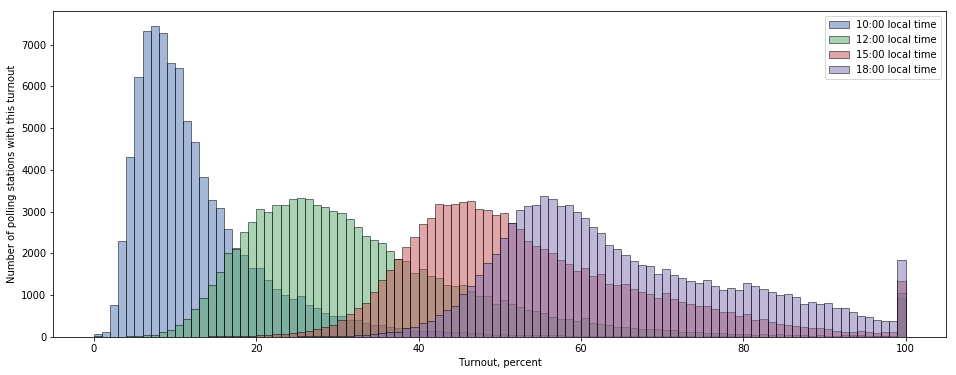

In [3]:
def calc_rounded_turnout(time):
    rounded_percentages = [int(round(t['turnout'])) for t in yield_turnout(time)]
    return rounded_percentages

plt.style.use('seaborn-deep')
plt.rcParams["patch.force_edgecolor"] = True
plt.figure(figsize=(16, 6))
plt.hist(calc_rounded_turnout('10:00'), 100, alpha=0.5, label='10:00 local time')
plt.hist(calc_rounded_turnout('12:00'), 100, alpha=0.5, label='12:00 local time')
plt.hist(calc_rounded_turnout('15:00'), 100, alpha=0.5, label='15:00 local time')
plt.hist(calc_rounded_turnout('18:00'), 100, alpha=0.5, label='18:00 local time')
plt.xlabel('Turnout, percent')
plt.ylabel('Number of polling stations with this turnout')
plt.legend()
print()

In [4]:
# A suprising number of polling station reported 100% turnout.
# What were they?
hundred_pct = sorted(['%(region)s / %(territory)s / %(polling_station)s %(turnout).2f' % t 
                      for t in yield_turnout('18:00') if t['turnout'] > 99])
len(hundred_pct)

1666

In [5]:
hundred_pct

['Алтайский край / Барнаул, Октябрьская / УИК №1910 100.00',
 'Алтайский край / Барнаул, Центральная / УИК №1913 100.00',
 'Алтайский край / Ребрихинская / УИК №1368 100.00',
 'Алтайский край / Рубцовская городская / УИК №1924 100.00',
 'Амурская область / Сковородинского района / УИК №1826 100.00',
 'Амурская область / города Благовещенск / УИК №3001 100.00',
 'Амурская область / города Благовещенск / УИК №3006 100.00',
 'Амурская область / города Благовещенск / УИК №3009 100.00',
 'Амурская область / города Шимановск / УИК №2112 100.00',
 'Архангельская область / Архангельск, Ломоносовская / УИК №47 100.00',
 'Архангельская область / Архангельск, Ломоносовская / УИК №48 99.04',
 'Архангельская область / Архангельск, Соломбальская / УИК №127 100.00',
 'Архангельская область / Архангельск, Южная / УИК №1000 100.00',
 'Архангельская область / Архангельск, Южная / УИК №1001 100.00',
 'Архангельская область / Архангельск, Южная / УИК №1002 100.00',
 'Архангельская область / Архангельск, Ю